In [0]:
from IPython.display import Image
from IPython.display import HTML
from IPython.display import YouTubeVideo




In [0]:
from google.colab import files
uploaded = files.upload() #movies.csv  perform.csv

Saving ratings.csv to ratings.csv
Saving movies.csv to movies.csv


# Theoretical Part
# Basics of The Recommender System
The reason why consumers need reliable recommendations is strightforward: Given the availability of almost unlimited number of choices (e.g. movies of various quaility), and  human natural tendecy to maximize her utility, a customer needs guidiance to find the next  best item that accomodates her needs/tastes. Specifically, Netflix has become so popular because of its capability to suggest the user a next movie (from thousands of other options) that matches the best with her preferences. 


## Types of the Systems
There are many many ways, algorithms, to build a recommender system. The following are other more complex approaches. I suggest the reader to think which one may be **the most effective system**, when it comes to a movie recommendation, while reading.


* **The Most Popular Item**:  Is the simplest strategy and requires no coding skills. It works based on the assumption that the most popular item attracts every consumer. For example, any consumer shopping on Amazon would see the the most requentelly bought iteams. Conversally,  anyone browsing Netflix would be recommended the most popular, i.e. frequenetelly watched, movie.

* **Asociation & Market Based Model:** The system makes recommendation based on the items in the consumer's basket. For instance, when the system decets the buyer is buying ground coffee it suggest her to buy filters as well because it observed the asscociation coffee - filters among other buyers in time.

* **Content Filtering:** Uses matadata to determine user's test. For example, the system recommends the users movies based on her preferences of genres, actors, themes, etc. Such system matches the user with item based on (cosine) similarity. For example, if the user watched and liked Terminator and Predator (both action movies with Arnold Schwarzenegger in the main role), it  would probably recommend the her to watch Commando.

* **Collaborative Filtering (CF):** Is an algorithmic architecture that recomends consumers items based on their past behaviour. There are two types Collaborative Filtering frameworks built on  either **Model Based Approach** or **Memory Based Approach**:

  * **User-based (UBCF):** Predecesor of Item-based CF Makes recommendations based of the characteristics shared with other similar users of the system.  For example, if  the end user positively rates a movie, the algorithm finds other users who have previously rated the movie too, i.e. these users are similar to the end one (or have  very similartaste). In a next step, the system recommends the user an unseen movie but highly rated by other - referenced - users. See  Figure 1 and Figure 2.
  
  * **Item-based (IBCF):**  Originally developed by Amazon and curently adopted by the most online corporations (e.g. Netflix, YouTube, etc.).

* **Hybrid Models:** As the name suggests, the Hybrid Models combine two or more recommendation strategies. For instance, a Hybrid Content-Collaborative System can recommend the user a movie based on her similar rating profile with other users but still focuses on the movie features the user exhibits to prefere. 

*While  **Hybrid Models** logically appear to be the most efectie ones, **Netflix's recomendation engine is based on the assumption that similar users like and dislike similar items**; i.e. **Collaborative Filtering** is the key of Netflix's success. The  following diagrams demonstrate how the system works.*

**The both SVD and NMF applied in the article are classified as IBCF**.


## Item-based (IBCF)


To tackle the issues with UBCF, item-based collaborative techniques analyze the
user-item matrix and identify relationships between different
items (Sar rwar et al.,2001). The item-based recommendation system then makes recommendations based on the discovered relationships among the items.
 


# Collaborative Fitering: Model Based Approach


Once again, this article discusses **Collaborative Item-based Filtering** and focuses on the **Model Based Approach** which tackles the two challanges imposed by CF. Unlike Memory Based Approach, **Model Based** procedure facilitates machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating of unrated items.



In the context of a movie-to-movie recommender, a collaborative filter answers the question: “What movies have a similar user-rating profile? https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af 

## Importing Packages and Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import defaultdict #?????????????????????????????????????????

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  ##CrossValidation
from surprise.model_selection import cross_validate


  ##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(42)

## DataFrames


[MovieLens](https://grouplens.org/datasets/movielens/) provides available rating datasets from the [MovieLens](http://movielens.org) web site (F. M. Harper and J. A. Konstan, 2015). Any researcher may use several different rating files with various number of rated movies and released time. For the demonstrative purpouses and limited computation power the author worked  with 100,836 ratings and 3,683 tag applications across 9,742 movies. The full description of the particular dataset can be found [here](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). According to the documentation, **the selected users in data rated at least 20 movies on the scale from 0.5 to 5** [^1].
[^1]: The dataset was last updated on 9/2018

The work considers only data contained in `ratings.csv` and `movies.csv`. After importing and storing the data as `pd.DataFrame` objects, one achieves two tidy data frames.

Specifically, `ratings_df` records `userId`,  `movieId`, and  `rating` consecutively.
On the other hand, `movies_df`  stores values in `movieId` and `genres`. `movieId` is therefore the mutual variable.  


Note that, `Surprise` enables to upload data,  e.g. csv files, for predictions through its own methods. On the other hand, as it is discussed below, `Surprise` also alows the user to use pandas' DataFrames. The author works with `pd.DataFrame` objects because of their eflexibility and transparency. 

In [0]:
ratings_df = (pd.read_csv("ratings.csv")).drop(columns = "timestamp")

movies_df = pd.read_csv("movies.csv")

## Inspecting The Data
One advantage of training on the particular dataset is  its cleaness; i.e. unlike in the real world, the researcher does not need to spend extra time with data cleansing. The following chunk and output demonstrates how the data is stored and in what format. Preciselly, the outputs exhibit the same values/data description as disclosed above.

In [0]:
#ratings
print(ratings_df.head())

print(ratings_df.info())

print(ratings_df.describe())

Note that `movies_df` contains only  `movieId` and `genres` varibles which store even multiple genres separted by the vertical bar in one cell.

In [0]:
ratings_df.rating.unique()

In [0]:
print(ratings_df.rating.value_counts())
print((1370/100836)*100)

In [0]:
#movies
print(movies_df.head())

## Data Pre-Processing




#### Filtering Data Set
Firstly, it is essential to filter out movies and users with low exposure to remove some of the noice from outliers. According to the official documentation, all selected users  rated at least 20 movies in the data set. However, the following code filters out the movies and users based on arbitrary treshold and creates new data frame `ratings_flrd_df`. Moreover, tho output of the chunk also prints the value of deleted movies and new and old dimensions. 

In [0]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)



"{0} movies deleted; movies rated at lest: {1} Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings_df.shape, ratings_flrd_df.shape )

'3446 movies deleted; movies rated at lest: 2 Old dimensions: (100836, 3); New dimensions: (97390, 3)'

## Data Loading
While using `Surprise`, one can use a bunch of built in datasets (e.g. Jeseter or even the movielens) parserd by `Dataset` module. Hower, one needs library custom data to build a customized recommender system. In such a case,  to upload own rating dataset either from a file (csv, etc.) or from a pandas dataframe. However, in both cases you will need to define a `Reader` object to parse the file or the dataframe by `Surprise`. See the reference [here](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset).

In next step, one must load the data set. It is achieved through the call of a particular method of `surprise.Dataset`. Specifically,  `load_from_file()` loads a csv file. However,  the author already uploaded and stored the data as `pd.DataFrame` objects for the already discussed reasons. Therefore, it is required to upload tthe data frame with ratings by user per movie with `Dataset.load_from_df` and specify `reader` as the argument.

Lastly,  `.build_full_trainset()` builds the train set from the entire data set. Traning on the whole data  and using the best hypertuning parameters is useful for the prediction of top arbitrary number of movies for each `userId`, as is demonstrated later. 

In [0]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()


The aim of the following and other sections is to explain particular methods of matrix factorization. Hower, the scope for each method is identical; i.e. the aouthor explains the model and demonstrates its performance. Since SVD is the first approach to be examined,  the scope differes a little. To avoid copy-pasting long chunk of codes, the author defines and explains two generic fuctions usefu for performance evaluation and predictions cosequtively in a greater datail. 

## Matrix Factorization
Hopcroft and Kannan (2012),  explains the whole concept of **matrix factorization** on cutomer data  where *m* customers buy *n* products. The authors reference the method to collaborative filtering in a comprehinsive language. For the demonstrative purpouses, the author demonstrates the concept on a specific this article's related case. 

Let matrix $A_{m*n}$ represent the ratings of movies assigned by each user, also called the utility matrix. Specifically, the value $a_{ij} = 5$ represents the rating of  user *i* assigned to movie  *j*. However,  the individual's preference is determined by *k* factors. For example, there user's age, sex, income, education, etc. are likely to effect his behavior. Accordingly, the invidual's rating of a movie ($a_{ij}$)  is determined by some weighted combinations of the hidden factors. **In practice, customers's behavior can be characterized by k-dimensional vector with much lower dimmesions than original $m * n$**. The vector's components  called the latent factors whicg represent the weight of each factor. For example, given a vector  $v_2 = [0.2 , 0.8]$ it can be hypothesized that there are only two (unknown) latent factors with subsequent weights describing the rating (behavior).

Matrix factirization is an effective CF technique because it benefits from  properties of linear algebra. Specifically, cosider metrix $A$ as a record of various elements. The same way it is possible to decompose any integer into the product of its prime factors, matrix factorization enables humans to display information about matrices and their functional properties an array of elements (Goodfellow, Bengio, 2016). 


## Singular Vector Decomoposition (SVD) 


SVD can decompose any matrix into **singular vectors** and **singular values**. If the reader of the article has a previous experience with machine learning, particularity with dimensionality reduction, one would find traditional use of SVD in  Principal Component Analysis (PCA). 
Simply, SVD is equivalent to (PCA) after mean centering, i.e. shifting all data points so that their mean is on the origin (Gillis, 2014).

\
**Formaly,  SVD is decomposition of a matrix A into the product of three matrices: $A_{m*n} = U_{m*m} D_{m*n} V_{n*n}^{t}$.**


\
Where $A_{m*n}$ denotes the utility matrix with *n* equal to the numbe of e.g. users and *m* number exposed movies (items). $U_{m*m}$ is a left singular orthogonal matrix, representing the relationship between users and **latent factors**  (Hopcroft & Kannan, 2012). $D_{m*n}$ is a diagonal matrix (with positive real values) describing the strength of each latent factor. $V_{n*n}^{t}$  (transpose) is a right singular  orthogonal matrix, indicating the **similarity between items and latent factors**.

\
The goal of SVD (and matrix factorization in general) is to decompose the matrix A  with many missing $a_{ij}$ and again multiply its components $U_{m*m} D_{m*n} V_{n*n}^{t}$. As the result, there are no missing values $a_{ij}$ and it is possible to recommend each user movies (items) they have not seen or purchased yet. To better understand linear alegebra behind SVD, one can watch  Gilbert Strang's lecturu on SVD for MIT OpenCourseWare on YouTube channel or visit refer to  NIT [Singular Value Decomposition (SVD) tutorial](http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)





### Number of Factors
#### Number of Factors and RMSE (Sample

For the demonstrative purpouse, let's examine the effect of number of latent factors *k* on the model's performance.  Specifically, it is posible to visualy observe the effect of the multiple factors on error measurement. As in supervised machine learning, `cross_validate` computes the error rate for each fold. The following for loop computes the average of RMSE given by the five folds and append the empty  list `rmse_svd`. Consequentely,  the list contains 100 measures of min RMSE given 100 consequitive values of *k* in each testset, and by five folds in every iteration.

In [0]:
def perf_matfax(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

In [0]:
rmse_svd = perf_matfax(SVD,data)

To replicate the plot of performence for each subsequent model, the following chunk defins the function `plot_rmse()` with twoo argumets where `rmse` :  list of float values and `algorithm` : name of the matrix factorization model as string.  The function returns the plot with two sublplots visualizing performence depending on number of factor. The secon plot zooms the plot and marks  *k* with the best performance, i.e. the minimum RMSE. 

In [0]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

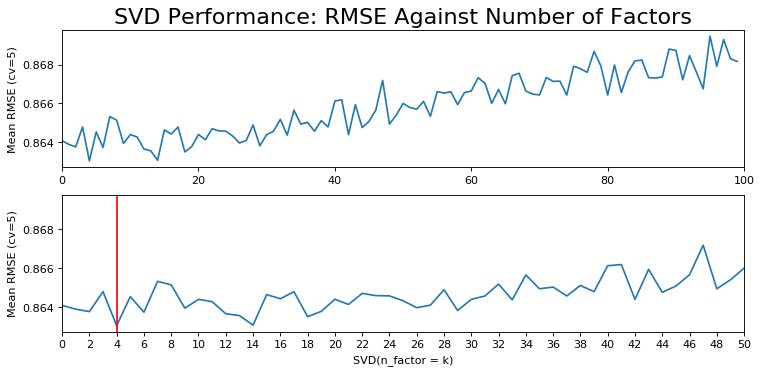

In [0]:
plot_rmse(rmse_svd,"SVD")

According to the figure, there is an increasing trend of worse performance with higher *k*. The lowest RMSE is achieved when $k=4$. However, it is worth of mention that $k=14$ is also very close to the  RMSE achived with only 4 latent factors. Besides, the author argues that it is not probable that the user's taste (rating) is determined by  such low nomber of factors. On the other hand, the result suggest a range of values which can be use in `GridSearchCV()`for  parameter tunning. 

### GridsearchCV (Sample)



In [0]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8639552777419859
{'n_factors': 11}


To make the model generalizable , i.e. avoid over and under fitting, the greedy algorithm finds $k=11$ for for `n_factors` argument optimal. 

### Training SVD Algorithm and Predictions
Next, `SVD(n_factors = 11)` fits the model on `trainset`. To predict values, i.e. rating, for each empty element $a_{ij}$ in the utility matrix, it is essential to specify: a.) the users and b.) particular movies that **are not** in the trainset. `build_anti_testset()` method of `trainset` serves the described goal. It returns a list of ratings (`testset`) that are **not** in the trainset or in entire utility matrix . Consequentely, it is possible to use the fitted model and predict ratings for the movies in `testset`. `algo_SVD.test(testset)`returns the list with predictions.


In [0]:
algo_SVD = SVD(n_factors = 11)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.953822490465707, details={'was_impossible': False})]

### Prediction and Historical Reference

One can observe the Python class list with predictions is a raw output and it would be dificult to serach for any `userId` and  predictions with meaningful information. For example, let's assume the are two goals: i.) suggest any `userId` the top 10 unseen movies the person is likely to enjoy and ii.) recommend the user movies with titles and genres. Overall, it was the author's obejctive  to define a function with the following properties:

  * Maping the predictions to each user.
  
  * Returning: i.) recommendations for any  given `userId` and  ii.)  the user's  historical ratings 
  
  * Returning the above objects with specific reference to the movie and its genre in a readable format (i.e. tidy DataFrame) 
  
The below  function  `get_top_n()` acomplishes the both goals. The function takes five arguments.   Specifically, `predictions` is the list with predictions (`predictions = algo_SVD.test(testset)`
) , `userId` is an arbitrary user's id, `movies_df` is dataframe with title and genre to each `movieId`, `ratings_df` containts histarical rating,  and `n` specifies how many movies should  be recommended to the user. By default, `n` is set to 10.
`get_top_n()` consists of two main parts:
\
\
Part I. comes from the official Surprice documentation. It maps the prediction to each users, sorts them in descendin order, and returns the  top n (by default 10) recommended movies for the `userId` specified as the argument of the function. 
\
\
Part II. was inspired by an [article](https://beckernick.github.io/matrix-factorization-recommender/) published by IVIDIA data scientist Nick Becker. It prints the total number of movies rated by the user. Then, it merges the DataFrame objects  history and predictions on `movieID` in `movies_df`. Therefore, besides `movieId` the both objects consequately contains `title` and `genres`.  One can then *holisticaly* evaluate the models performance on individual level becase the function's output (data frames) allows to observe both the highes rated predictions and the highest rated movies in the past. It is assumed that higly rated genres should correspond to the user's taste and are therefore expected to appear in the recommended movies.

In [0]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

### SVD Recommendations
In this stage, it is already possible to to suggest any any `userID` `n` movies based on her historical ratings because the model was properly train with gridsearch method. Additionally, based on the acquired predictions and defined `get_top_n()` function it is possible to visually inspect the recommended movies and user's best rated movies in the past. For instance, let's assume the `userId` 124 is interested in watching a movie tonigh but has no specific title in her mind. On top of that, the movie database containes over 6,000 titles across mutliple genres so the user would spend a lot of time on researching what movies are in line with her **specific preferences**. The following code makes the user's choice much more easier. After calling `get_top_n()` function, it is immediatelly obvious the user 124 has already rated 50 movies. 

In [0]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

To see the user's history, let's examine her top 15 highest rated movies.  The ratings are in the range from 5 to 4.5. As the table bellow show,  the user 124 enjoys a wide range of genres.  Specifically, the top highest rated movies (rating 5) are mostly dramas. Additionally, the user also higly rated comedies, thrillers, and action/adventure movies.

In [0]:
hist_SVD_124.head(15)

,userId,movieId,rating,title,genres
0,124,1358,5.0,Sling Blade (1996),Drama
1,124,3949,5.0,Requiem for a Dream (2000),Drama
2,124,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,6377,5.0,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,2858,5.0,American Beauty (1999),Drama|Romance
5,124,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,608,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,3252,4.5,Scent of a Woman (1992),Drama
8,124,1210,4.5,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,1196,4.5,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


When it comes to the predictions

In [0]:
pred_SVD_124

,userId,movieId,rat_pred,title,genres
0,124,750,4.610126,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
1,124,1136,4.545477,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
2,124,904,4.541237,Rear Window (1954),Mystery|Thriller
3,124,1208,4.537614,Apocalypse Now (1979),Action|Drama|War
4,124,1204,4.535593,Lawrence of Arabia (1962),Adventure|Drama|War
5,124,56782,4.517568,There Will Be Blood (2007),Drama|Western
6,124,1225,4.513478,Amadeus (1984),Drama
7,124,898,4.512611,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
8,124,2959,4.510696,Fight Club (1999),Action|Crime|Drama|Thriller
9,124,2160,4.499703,Rosemary's Baby (1968),Drama|Horror|Thriller



## Non-Negative Matrix Factorization (NMF)

NMF is another method used for matrix factorization. Contrary to SVD, NMF decomposes the **non-negative** utility matrix V into the product of matrices *W* and *H* :
\
$V_{n*d} = W_{n*r} H_{r*d}$**

Where columns in matrix $W_{n*r}$ represent components, while matrix $H_{r*d}$ stores the coresponsing weights. More importantaly,  NMF introduces constrains under which: $W \geq 0$ and $H \geq 0$. The component-wise nonnegativity is substentional difference from SVD (Gillis, 2017). Besides, collaborative filtering one can find use cases of NMF in clusterig, image processing,  or music analysis. 



In [0]:
rmse_nmf = rmse_vs_factors(NMF, data)

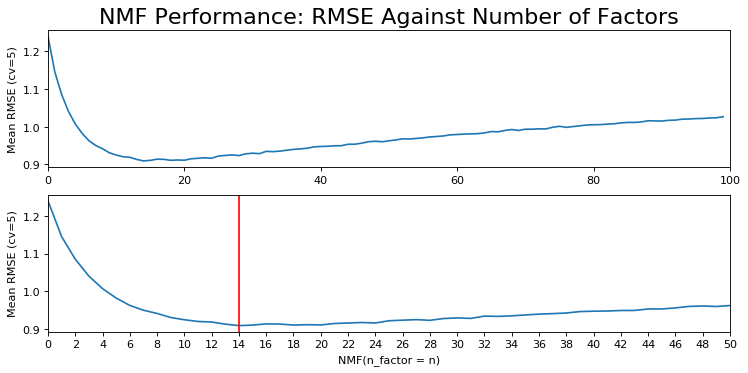

In [0]:
plot_rmse(rmse_nmf, "NMF")

In [0]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)



# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8861525979842921
{'n_factors': 17}


In [0]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [0]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, original_ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [0]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,2324,4.604147,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War
1,124,1089,4.558471,Reservoir Dogs (1992),Crime|Mystery|Thriller
2,124,1213,4.548465,Goodfellas (1990),Crime|Drama
3,124,1248,4.544143,Touch of Evil (1958),Crime|Film-Noir|Thriller
4,124,1104,4.541697,"Streetcar Named Desire, A (1951)",Drama
5,124,750,4.536357,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
6,124,904,4.530793,Rear Window (1954),Mystery|Thriller
7,124,1235,4.526960,Harold and Maude (1971),Comedy|Drama|Romance
8,124,1242,4.517884,Glory (1989),Drama|War
9,124,898,4.512130,"Philadelphia Story, The (1940)",Comedy|Drama|Romance


## Probabilistic Matrix Factorization (PMF)
Contrary to the previous models presented in this work, PMF is not the based on linear algebra. Though, PMF is the subject of probability theory. As  other probabilistic models,  PMF also assumes Gaussian distribution of data generated by random process.  Therefore, the motivation of PMF is to learn the parameters in the training and predict the missing values, i.e. ratings,  based on normal probabilistic distribution. 

In this particular case, the goal of the model is to predict probability the user $u$ will rate movie $m$ with rating $r_{um}$. However,  $r_{um}$ is deteremined by an unknown number of parameters. Again, it is possible to decompose the probability the user will rate movie $m$ into latent factors. Such probability depends on summation of a product of two probability functions and can be expressed as:


$P( r_{um} | u ) = \sum_{z} P( r_{um} | z) P(z|u)$


Where   $P( r_{um} | z)$ probability that recieved rating for movie $m$ given by user $u$ depends on movie feature $z$ but not the user $u$. Contrary, $P(z|u)$ is the probability that particular user will choose the feature $z$ and depends on the user. In other words, how likely is the user to enjoy, for example, action movies.


When it comes to matrix factorization, PMF is similar to SVD. Note that $A_{n*d} = U_{n*r} D_{r*r} V_{r*d}^{t}$ can be also simplified as $A_{n*d} = U_{n*r} V_{r*d}^{t}$. In such case the strength of latent factors in diagonal matrix $D_{r*r}$ would be encoded in  $U_{n*r}$. 


Therefore, PMF is comonly expressed as:


$R = P Q^T$

Where both $P$ and $Q^T$ are stochastic matrices, i.e. they are not orthogonal and are square. Again, the matrices encode probability distributions instead of linear algebra vector spaces. A stochastic matrix is also called probabilistic or Markow matrix. Additionally, $P$ matrix strores $P(z|u)$  while values in $Q^T$ represent $P( r_{um} | z)$.

Since PMF assumes normal distributions of ratings  $r_{um}$, the mean on the bell curve is determined by the forrmula:


$r_{um} \sim N(q_u p_{m}^T, \sigma^2)$



Where $N$ is the mean that depends on dot product of user feature vector $q_u$ and movie feature vector $ p_{m}^T$, and some noice/variance s $\sigma^2)$


In [0]:
from scipy import stats
stats.normaltest(ratings_df["rating"])

#This function tests the null hypothesis that a sample comes from a normal distribution. 
#It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis 
#to produce an omnibus test of normality.

NormaltestResult(statistic=5822.370481158027, pvalue=0.0)

In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.RobustScaler()

scaled = min_max_scaler.fit_transform(ratings_df[["rating"]])


In [0]:
stats.normaltest(scaled)


NormaltestResult(statistic=array([5822.37048116]), pvalue=array([0.]))

(array([ 1370.,  2811.,  1791.,  7551.,  5550., 20047., 13136., 26818.,
         8551., 13211.]),
 array([-3.  , -2.55, -2.1 , -1.65, -1.2 , -0.75, -0.3 ,  0.15,  0.6 ,
         1.05,  1.5 ]),
 <a list of 1 Patch objects>)

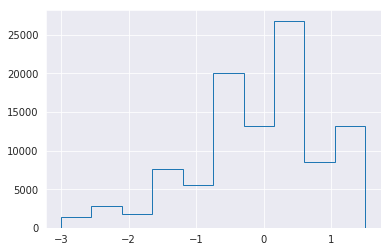

In [0]:
plt.hist(scaled,histtype="step")

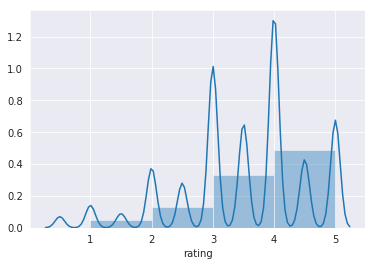

In [0]:
sns.set_style('darkgrid')
sns.distplot(ratings_df["rating"], bins= [1,2,3,4,5], hist = True)
plt.show()

In [0]:
PMF()

In [0]:
class PMF(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,n_factors, learning_rate = 0.05, n_epochs = 4):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.n_epochs = n_epochs
        self.n_factors = n_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.n_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.n_factors))
        #print('fit')

        for epoch in range(self.n_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean
                

In [0]:
rmse_PMF = perf_matfax(PMF,data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


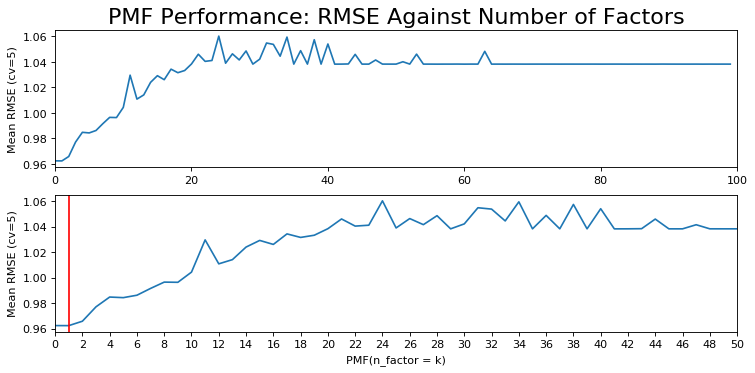

In [0]:
plot_rmse(rmse_PMF, "PMF")

In [0]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(PMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)



# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


1.0209118624961184
{'n_factors': 11}


In [0]:
algo_PMF = PMF(n_factors = 11)
algo_PMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions_PMF = algo_PMF.test(testset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


In [0]:
hist_PMF_124, pred_PMF_124 = get_top_n(predictions_PMF, movies_df = movies_df, userId = 124, original_ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [0]:
pred_PMF_124

,userId,movieId,rat_pred,title,genres
0,124,3,3.511043,Grumpier Old Men (1995),Comedy|Romance
1,124,6,3.511043,Heat (1995),Action|Crime|Thriller
2,124,47,3.511043,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
3,124,70,3.511043,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
4,124,101,3.511043,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
5,124,151,3.511043,Rob Roy (1995),Action|Drama|Romance|War
6,124,157,3.511043,Canadian Bacon (1995),Comedy|War
7,124,163,3.511043,Desperado (1995),Action|Romance|Western
8,124,216,3.511043,Billy Madison (1995),Comedy
9,124,223,3.511043,Clerks (1994),Comedy
